<a href="https://colab.research.google.com/github/qkrtnwjd4212/Time_Series_Data_Project/blob/main/final_TJX.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### 🔗 Install & Import

In [ ]:
!pip install nbstripout
!nbstripout /content/your_notebook.ipynb # 깃허브에서 preview 안 보이는 문제 해결

In [ ]:
!pip install ta
!pip install pygad
!pip install backtesting
!pip install reservoirpy

!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

!cp "/content/drive/MyDrive/Colab Notebooks/stock/"
# !cp "/content/drive/MyDrive/Colab Notebooks/시계열팀플/tictocstock_trend.csv" "/content/"
# !cp "/content/drive/MyDrive/Colab Notebooks/시계열팀플/data/tictocstock.csv" "/content/"

In [28]:
import pandas as pd
import seaborn as sns
import numpy as np
from sklearn.preprocessing import StandardScaler
import pygad
from backtesting import Backtest, Strategy
from datetime import timedelta
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score
import torch
import torch.nn as nn
from reservoirpy.observables import nrmse, rsquare
from reservoirpy.nodes import Reservoir, Ridge
from scipy.stats import ttest_ind
from sklearn.model_selection import ParameterGrid
plt.rc('font', family='NanumBarunGothic')

### 📈 Make Trend Data

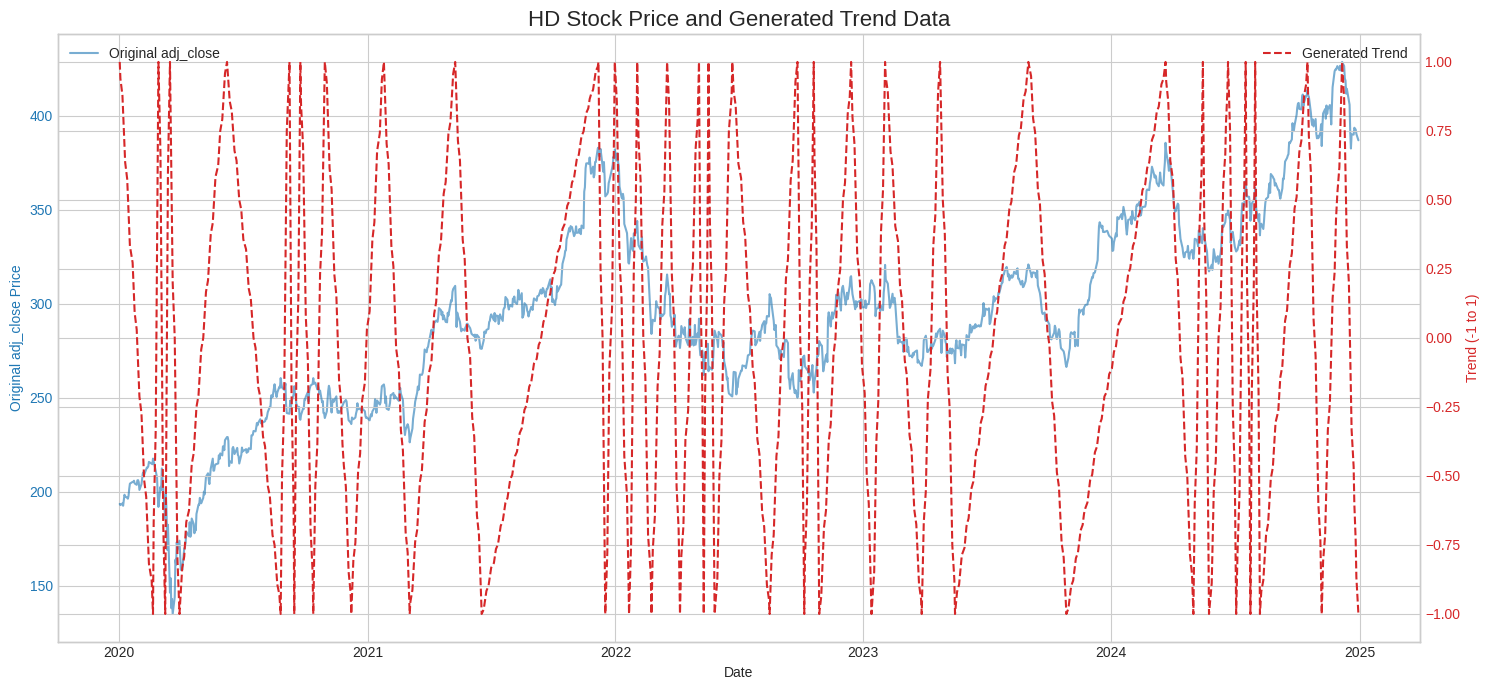

In [29]:
# 1) ZigZag 알고리즘으로 반전 지점 찾기
def _find_turning_points_zigzag(prices, P_threshold_pct, T_threshold_periods):
    if len(prices) < 2:
        return []

    turning_points = [0]
    last_pivot_idx = 0
    last_pivot_price = prices[0]
    trend = 0  # 1: 상승, -1: 하락

    # 현재 스윙의 잠재적 극단점(고점 또는 저점)
    candidate_pivot_idx = 0
    candidate_pivot_price = prices[0]

    for i in range(1, len(prices)):
        current_price = prices[i]
        price_diff_pct = abs((current_price - last_pivot_price) / last_pivot_price) * 100

        if trend == 0:  # 초기 추세 결정
            if price_diff_pct >= P_threshold_pct:
                trend = 1 if current_price > last_pivot_price else -1
                candidate_pivot_idx = i
                candidate_pivot_price = current_price

        elif trend == 1:  # 상승 추세 중
            if current_price > candidate_pivot_price:
                candidate_pivot_idx = i
                candidate_pivot_price = current_price
            # 고점 후보에서 P_threshold_pct 이상 하락 시, 고점 확정
            elif ((candidate_pivot_price - current_price) / candidate_pivot_price) * 100 >= P_threshold_pct:
                if (candidate_pivot_idx - last_pivot_idx) >= T_threshold_periods:
                    turning_points.append(candidate_pivot_idx)
                    last_pivot_idx, last_pivot_price = candidate_pivot_idx, candidate_pivot_price
                trend = -1
                candidate_pivot_idx, candidate_pivot_price = i, current_price

        elif trend == -1:  # 하락 추세 중
            if current_price < candidate_pivot_price:
                candidate_pivot_idx = i
                candidate_pivot_price = current_price
            # 저점 후보에서 P_threshold_pct 이상 상승 시, 저점 확정
            elif ((current_price - candidate_pivot_price) / candidate_pivot_price) * 100 >= P_threshold_pct:
                if (candidate_pivot_idx - last_pivot_idx) >= T_threshold_periods:
                    turning_points.append(candidate_pivot_idx)
                    last_pivot_idx, last_pivot_price = candidate_pivot_idx, candidate_pivot_price
                trend = 1
                candidate_pivot_idx, candidate_pivot_price = i, current_price

    # 마지막 지점을 추가하여 트렌드 라인이 끝나도록 함
    if turning_points[-1] != len(prices) - 1:
        turning_points.append(len(prices) - 1)

    return turning_points

# 2) 트렌드 데이터 생성(P, T 값 5로 고정)
def generate_trend_data(df_stock, P_threshold_pct=5.0, T_threshold_periods=5):

    prices = df_stock['adj close'].values

    # 주요 반전 지점(turning points) 찾기
    tp_indices = _find_turning_points_zigzag(prices, P_threshold_pct, T_threshold_periods)

    if len(tp_indices) < 2:
        return pd.Series(np.zeros(len(df_stock)), index=df_stock.index, name='trend')

    # 반전 지점에 -1(저점) 또는 1(고점) 할당
    trend_values = pd.Series(index=df_stock.index, dtype=float)

    # 첫 번째 반전 지점의 유형 결정 (상승 시작인지 하락 시작인지)
    first_swing_price_change = prices[tp_indices[1]] - prices[tp_indices[0]]
    current_trend_val = 1.0 if first_swing_price_change > 0 else -1.0

    for idx in tp_indices:
        trend_values.loc[df_stock.index[idx]] = current_trend_val
        current_trend_val *= -1 # 다음 반전 지점은 부호 반전

    # 반전 지점 사이를 선형 보간
    trend_series = trend_values.interpolate(method='linear')
    trend_series = trend_series.bfill().ffill()

    return trend_series

# ================================= 메인 실행 로직 =================================
# 1) 데이터 로드
df_all = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/tictocstock.csv", parse_dates=['Date'])
df_all.columns = df_all.columns.str.strip().str.lower()
df_all['date'] = pd.to_datetime(df_all['date'])

processed_dfs = []  # 결과를 저장할 빈 리스트
tickers = df_all['ticker'].unique()

# 2) 트렌드 데이터 만들기
for ticker in tickers:
    df_stock = df_all[df_all['ticker'] == ticker].copy().sort_values('date').set_index('date')

    # 트렌드 데이터: P는 5% 이상 변동, T는 5일 이상 지속되는 추세만 인정
    trend_data = generate_trend_data(df_stock, P_threshold_pct=5.0, T_threshold_periods=5)
    df_stock['trend'] = trend_data

    processed_dfs.append(df_stock.reset_index())  # 인덱스를 다시 컬럼으로

df_final = pd.concat(processed_dfs, ignore_index=True)  # 데이터프레임 합치기

# 3) 최종 결과 CSV 파일로 저장
output_filename = '/content/tictocstock_trend_adjclose.csv'
df_final.to_csv(output_filename, index=False)

# ================================= 결과 차트 시각화 =================================
# 1) 결과 확인 (첫 번째 종목의 차트 시각화)
first_ticker = tickers[0]
df_sample = df_final[df_final['ticker'] == first_ticker].set_index('date')

plt.style.use('seaborn-v0_8-whitegrid')
fig, ax1 = plt.subplots(figsize=(15, 7))

# 2) 첫 번째 Y축 (가격)
ax1.set_title(f'{first_ticker} Stock Price and Generated Trend Data', fontsize=16)
ax1.set_xlabel('Date')
ax1.set_ylabel('Original adj_close Price', color='tab:blue')
ax1.plot(df_sample.index, df_sample['adj close'], color='tab:blue', alpha=0.6, label='Original adj_close')
ax1.tick_params(axis='y', labelcolor='tab:blue')
ax1.legend(loc='upper left')

# 3) 두 번째 Y축 (트렌드)
ax2 = ax1.twinx()
ax2.set_ylabel('Trend (-1 to 1)', color='tab:red')
ax2.plot(df_sample.index, df_sample['trend'], color='tab:red', linestyle='--', label='Generated Trend')
ax2.tick_params(axis='y', labelcolor='tab:red')
ax2.legend(loc='upper right')
ax2.set_ylim(-1.1, 1.1)

fig.tight_layout()
plt.show()

### 🔁 GA optimization 3 times

In [30]:
tmp = pd.read_csv("/content/tictocstock_trend_adjclose.csv")
tmp.rename(columns={'adj close': 'adj_close'}, inplace=True)

tmp.to_csv("/content/tictocstock_trend_adjclose.csv", index=False)

tmp = pd.read_csv("/content/tictocstock_trend_adjclose.csv")
tmp.head()

,date,adj_close,close,high,low,open,volume,ticker,trend
0,2020-01-02,193.498154,219.660004,219.759995,217.839996,219.080002,3935700,HD,1.000000
1,2020-01-03,192.855072,218.929993,219.679993,216.750000,217.139999,3423200,HD,0.939394
2,2020-01-06,193.762421,219.960007,220.000000,216.399994,216.490005,5682800,HD,0.878788
3,2020-01-07,192.493927,218.520004,220.559998,216.899994,219.500000,5685400,HD,0.818182
4,2020-01-08,195.374435,221.789993,222.970001,218.669998,218.800003,4916200,HD,0.757576


In [31]:
'''
백테스트시, 수정 종가는 스무딩 하지 않는다.
'''
# GDC 기반 전략 (매도 시 1% 수수료) - 기존 코드
class GDCStrategy(Strategy):
    def init(self):
        self.signal = self.data.signal
        self.last_signal = None

    def next(self):
        # ==================== 마지막날에 남은 주식을 모두 매도하는 로직 ====================
        if self.I == len(self.data) - 1:
            if self.position:
                self.position.close()
            return

        current_signal = self.signal[-1]  # ✅ 현재 시점의 시그널값

        # ==================== 매수, 매도 시그널 수정 (1: 매수, -1: 매도) ====================
        if self.position:
            if current_signal == 1 and self.position.is_short:
                self.position.Close()
                self.buy()

            elif current_signal == -1 and self.position.is_long:
                self.position.Close(size=self.position.size, reduce_only=False)
                self.sell()
        else:
            if current_signal == 1:
                self.buy()
            elif current_signal == -1:
                self.sell()

# SMA, EMA, MACD, RSI, Stochastic, ROC만 사용
def compute_indicators(df, params):
    # 어떤 형태의 df가 들어오든, 필요한 컬럼만 추출하여 중복 없는 깨끗한 데이터프레임을 새로 만듦.
    clean_df = pd.DataFrame({
        'open': df['open'].iloc[:, 0] if isinstance(df['open'], pd.DataFrame) else df['open'],
        'high': df['high'].iloc[:, 0] if isinstance(df['high'], pd.DataFrame) else df['high'],
        'low': df['low'].iloc[:, 0] if isinstance(df['low'], pd.DataFrame) else df['low'],
        'adj_close': df['adj_close'].iloc[:, 0] if isinstance(df['adj_close'], pd.DataFrame) else df['adj_close'],
        'volume': df['volume'].iloc[:, 0] if isinstance(df['volume'], pd.DataFrame) else df['volume']
    }, index=df.index)
    df = clean_df
    c = df['adj_close'] # 스무딩 되지 않은 수정종가

    # SMA
    df['SMA'] = c.rolling(int(params[0])).mean() - c.rolling(int(params[1])).mean()

    # EMA
    df['EMA'] = c.ewm(span=int(params[2]), adjust=False).mean() - c.ewm(span=int(params[3]), adjust=False).mean()

    # MACD
    macd_fast = c.ewm(span=int(params[4]), adjust=False).mean()
    macd_slow = c.ewm(span=int(params[5]), adjust=False).mean()
    df['MACD'] = macd_fast - macd_slow
    df['MACD_Signal'] = df['MACD'].ewm(span=9, adjust=False).mean()

    # RSI
    delta = c.diff()
    up = delta.clip(lower=0)
    down = -delta.clip(upper=0)
    # ma_up = up.rolling(int(params[6])).mean()
    # ma_down = down.rolling(int(params[6])).mean()
    # EMA 방식 (Wilder의 방식에 가까움)
    ma_up = up.ewm(span=int(params[6]), adjust=False).mean()
    ma_down = down.ewm(span=int(params[6]), adjust=False).mean()
    rs = ma_up / (ma_down + 1e-10)
    df['RSI'] = 100 - (100 / (1 + rs))

    # Stochastic: %K, %D
    low_min = df['low'].rolling(int(params[7])).min()
    high_max = df['high'].rolling(int(params[7])).max()
    df['Stoch_K'] = (c - low_min) / (high_max - low_min + 1e-10) * 100
    df['Stoch_D'] = df['Stoch_K'].rolling(3).mean()

    # ROC
    df['ROC'] = c.pct_change(periods=int(params[8])) * 100

    return df.dropna().copy()

# 신호 생성 함수 - 지정된 단일 지표에 대한 매매 신호(-1, 0, 1) 생성하도록 변경
def generate_single_indicator_signal(df, indicator_name):
    signals = pd.Series(index=df.index, data=0) # 0으로 초기화

    if indicator_name == 'SMA':
        signals[df['SMA'] > 0] = 1 # 단기 > 장기 (매수)
        signals[df['SMA'] < 0] = -1  # 단기 < 장기 (매도)
    elif indicator_name == 'EMA':
        signals[df['EMA'] > 0] = 1
        signals[df['EMA'] < 0] = -1
    elif indicator_name == 'MACD':
        signals[df['MACD'] > df['MACD_Signal']] = 1 # MACD > Signal (매수)
        signals[df['MACD'] < df['MACD_Signal']] = -1  # MACD < Signal (매도)
    elif indicator_name == 'RSI':
        signals[df['RSI'] < 30] = 1 # 과매수 (매수)
        signals[df['RSI'] > 70] = -1  # 과매도 (매도)
    elif indicator_name == 'Stochastic':
        signals[df['Stoch_K'] > df['Stoch_D']] = 1 # %K > %D (매수)
        signals[df['Stoch_K'] < df['Stoch_D']] = -1  # %K < %D (매도)
    elif indicator_name == 'ROC':
        signals[df['ROC'] > 0] = 1 # 상승 추세 (매수)
        signals[df['ROC'] < 0] = -1  # 하락 추세 (매도)

    # return signals.values
    return signals

# 커스텀 수수료 (매도 시에만 1% 적용)
def safe_commission(trade, order):
    try:
        return 0.01 * trade.value if hasattr(trade, 'is_short') and (trade.is_short or trade.side == 'sell') else 0
    except Exception:
        return 0


# 백테스트 함수 (adj close -> Close)
def backtest(df, signal):
    df_bt = df.copy()
    df_bt['signal'] = signal
    df_bt = df_bt[['open', 'high', 'low', 'adj_close', 'volume', 'signal']].dropna()
    df_bt.rename(columns={'open': 'Open', 'high': 'High', 'low': 'Low', 'adj_close': 'Close', 'volume': 'Volume'}, inplace=True)
    df_bt.index.name = 'Date'

    bt = Backtest(
        df_bt,
        GDCStrategy,
        cash=10_000, # 1만 달러
        commission=safe_commission,
        exclusive_orders=True
    )

    stats = bt.run()

    return stats['Return [%]'] / 100, stats['Max. Drawdown [%]'] / 100, stats['Sharpe Ratio']

In [ ]:
# ================================= 메인 실행 로직 =================================
# 데이터 로드 및 전처리
df_all = pd.read_csv("/content/tictocstock_trend_adjclose.csv", parse_dates=['date'])
df_all.columns = df_all.columns.str.strip()
df_all.sort_values(['ticker', 'date'], inplace=True)

# TJX 데이터
df = df_all[df_all['ticker'] == 'TJX'].set_index('date').copy().ffill()

# 학습/테스트 분리 (최근 12개월 테스트)
split_date = df.index.max() - pd.DateOffset(months=12)
df_train = df[df.index < split_date].copy()
df_test = df[df.index >= split_date].copy()
print(df_train.columns)

print("\U0001F4D8 학습 데이터 기간:", df_train.index.min().date(), "~", df_train.index.max().date())
print("\U0001F4D9 백테스트 데이터 기간:", df_test.index.min().date(), "~", df_test.index.max().date())

# 지표별 유전자 설정 (파라미터 범위 확장)
indicator_configs = {
    'SMA':        {'param_indices': [0, 1], 'gene_space': [{'low': 5, 'high': 100}, {'low': 10, 'high': 200}]},
    'EMA':        {'param_indices': [2, 3], 'gene_space': [{'low': 5, 'high': 20}, {'low': 21, 'high': 60}]},
    'MACD':       {'param_indices': [4, 5], 'gene_space': [{'low': 5, 'high': 20}, {'low': 21, 'high': 100}]},
    'RSI':        {'param_indices': [6],    'gene_space': [{'low': 5, 'high': 90}]},
    'Stochastic': {'param_indices': [7],    'gene_space': [{'low': 5, 'high': 40}]},
    'ROC':        {'param_indices': [8],    'gene_space': [{'low': 5, 'high': 30}]},
}

# 타겟 데이터 (트렌드)
Y_target_trend = df_train['trend'].values

# all_best_params = {}
# ga_instances = {}

# 피트니스 시각화 함수 정의
def plot_ga_fitness(ga_instance, indicator_name):
    plt.figure(figsize=(10, 5))
    plt.plot(ga_instance.best_solutions_fitness, label='Best Fitness per Generation', color='blue', marker='.')
    plt.title(f'[{indicator_name}] GA Fitness Over Generations')
    plt.xlabel('Generation')
    plt.ylabel('Fitness (Matching Score)')
    plt.grid(True)
    plt.legend()
    plt.show()

# ================================= GA 3회 반복 최적 파라미터 선별 및 백테스트 =================================
N_RUNS = 3  # GA 최적화 및 백테스트 반복 횟수
final_best_params = {}
final_best_stats = {}

print("\n=================== GA 3회 반복 후 최적 성능 기준 파라미터 선정 ===================")


for indicator_name, config in indicator_configs.items():
    print(f"\n▶ {indicator_name} 최적화 및 백테스트 {N_RUNS}회 반복")
    best_score = -np.inf
    best_params = None

    for run in range(N_RUNS):
        print(f" - Run {run+1}/{N_RUNS}")

        def fitness_func(ga_instance, solution, solution_idx):
            try:
                current_params = [10] * 9
                for i, p_idx in enumerate(config['param_indices']):
                    current_params[p_idx] = int(round(solution[i]))

                if 'SMA' in indicator_name and current_params[0] >= current_params[1]: return -np.inf
                if 'EMA' in indicator_name and current_params[2] >= current_params[3]: return -np.inf
                if 'MACD' in indicator_name and current_params[4] >= current_params[5]: return -np.inf

                df_ind = compute_indicators(df_train, current_params)
                signal = generate_single_indicator_signal(df_ind, indicator_name).values
                aligned_Y_target = Y_target_trend[-len(signal):]
                matching_score = np.sum(signal * aligned_Y_target)
                return matching_score
            except:
                return -np.inf

        ga = pygad.GA(
            num_generations=50,
            num_parents_mating=20,
            fitness_func=fitness_func,
            sol_per_pop=20,
            num_genes=len(config['gene_space']),
            gene_space=config['gene_space'],
            gene_type=float,
            mutation_type="random",
            mutation_num_genes=1,
        )

        ga.run()
        best_solution, _, _ = ga.best_solution()
        rounded_params = [int(round(g)) for g in best_solution]

        # 테스트셋에서 백테스트 성능 평가
        test_params = [10] * 9
        for i, p_idx in enumerate(config['param_indices']):
            test_params[p_idx] = rounded_params[i]

        try:
            df_test_ind = compute_indicators(df_test, test_params)
            signal_test = generate_single_indicator_signal(df_test_ind, indicator_name)
            profit, mdd, sharpe = backtest(df_test_ind, signal_test)
            score = profit  # 기준: 수익률 (Sharpe 등으로 변경 가능)

            print(f"   → 수익률: {profit:.4f}, Sharpe: {sharpe:.3f}, MDD: {mdd:.3f}")
            if score > best_score:
                best_score = score
                best_params = rounded_params
        except Exception as e:
            print(f"   ✖ 백테스트 오류: {e}")
            continue

    final_best_params[indicator_name] = best_params
    final_best_stats[indicator_name] = best_score

In [33]:
print("\n 최종 선택된 지표별 최적 파라미터:")
for ind in final_best_params:
    print(f"{ind:12} → {final_best_params[ind]} | 성능 점수(수익률): {final_best_stats[ind]:.4f}")


 최종 선택된 지표별 최적 파라미터:
SMA          → [94, 122] | 성능 점수(수익률): 0.0899
EMA          → [19, 60] | 성능 점수(수익률): 0.2581
MACD         → [5, 30] | 성능 점수(수익률): -0.2581
RSI          → [12] | 성능 점수(수익률): 0.0000
Stochastic   → [11] | 성능 점수(수익률): -0.2644
ROC          → [6] | 성능 점수(수익률): -0.2581


### 📈 Result visualization

In [ ]:
# 최적화된 각 지표별로 테스트 데이터 백테스트 실행 ==============================
results = []

base_params = [10] * 9
for indicator_name, best_params_for_indicator in final_best_params.items(): # final_best_params | all_best_params
    current_test_params = base_params.copy()
    config = indicator_configs[indicator_name]
    for i, p_idx in enumerate(config['param_indices']):
        current_test_params[p_idx] = best_params_for_indicator[i]

    df_test_ind = compute_indicators(df_test, current_test_params)
    signal_test = generate_single_indicator_signal(df_test_ind, indicator_name)
    profit, mdd, sharpe = backtest(df_test_ind, signal_test)

    results.append({
        'Indicator': indicator_name,
        'Profit [%]': round(profit * 100, 2),
        'Max. Drawdown [%]': round(mdd * 100, 2),
        'Sharpe Ratio': round(sharpe, 3)
    })

    print(f"\n[{indicator_name}] 백테스트 결과")
    print(f"  - 수익률: {results[-1]['Profit [%]']}%")
    print(f"  - MDD: {results[-1]['Max. Drawdown [%]']}%")
    print(f"  - Sharpe Ratio: {results[-1]['Sharpe Ratio']}")

    # 매매 신호 시각화
    plt.figure(figsize=(15, 7))
    plt.plot(df_test_ind.index, df_test_ind['adj_close'], label='adj_close Price', color='gray', alpha=0.7)

    # backtesting 라이브러리의 신호 규칙(매수 1, 매도 -1)에 맞춰서 시각화
    signal_series = pd.Series(signal_test, index=df_test_ind.index)
    buy_signals = df_test_ind[signal_series == 1]
    sell_signals = df_test_ind[signal_series == -1]

    plt.scatter(buy_signals.index, buy_signals['adj_close'], marker='^', color='green', label='Buy Signal', s=120, zorder=5, linewidths=1, edgecolors='black')
    plt.scatter(sell_signals.index, sell_signals['adj_close'], marker='v', color='red', label='Sell Signal', s=120, zorder=5, linewidths=1, edgecolors='black')

    plt.title(f"{indicator_name} Trade signal", fontsize=16)
    plt.xlabel("Date")
    plt.ylabel("Price")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [35]:
# 결과 요약 출력
results_df = pd.DataFrame(results).set_index('Indicator')
average_results = results_df.mean()

print("\n=================== 백테스트 결과 요약 ===================")
print(results_df)

print("\n=================== 평균 성능 ===================")
print(f"평균 수익률: {average_results['Profit [%]']:.2f}%")
print(f"평균 MDD: {average_results['Max. Drawdown [%]']:.2f}%")
print(f"평균 Sharpe Ratio: {average_results['Sharpe Ratio']:.3f}")


=================== 백테스트 결과 요약 ===================
            Profit [%]  Max. Drawdown [%]  Sharpe Ratio
Indicator                                              
SMA               8.99              -6.69         0.863
EMA              25.81              -8.58         1.240
MACD            -25.81             -35.08        -1.595
RSI               0.00              -0.00           NaN
Stochastic      -26.44             -35.54        -1.629
ROC             -25.81             -35.08        -1.595

=================== 평균 성능 ===================
평균 수익률: -7.21%
평균 MDD: -20.16%
평균 Sharpe Ratio: -0.543


### 🚀 Training ESN & Hyperparameter Tuning

In [36]:
df_ticker = df_all[df_all['ticker'] == 'TJX'].set_index('date').copy().ffill()
df_esn_input = pd.DataFrame(index=df_ticker.index) # ESN 입력을 담을 데이터프레임

# 입력 데이터(X) 만들기 - 지표별 최적 파라미터로 시그널 생성
for indicator_name, best_params in final_best_params.items():
    current_params = base_params.copy()
    config = indicator_configs[indicator_name]
    for i, p_idx in enumerate(config['param_indices']):
        current_params[p_idx] = best_params[i]

    df_with_indicator = compute_indicators(df_ticker, current_params)
    signals = generate_single_indicator_signal(df_with_indicator, indicator_name)

    df_esn_input[indicator_name] = pd.Series(signals, index=df_with_indicator.index)

# 타겟 데이터(Y)와 입력 데이터(X)의 날짜를 맞추고 결측치 제거
df_final_esn_data = df_ticker.join(df_esn_input).dropna()

# 최종 X, Y 데이터 정의
feature_columns = list(final_best_params.keys()) # ['SMA', 'EMA', ...]
X = df_final_esn_data[feature_columns].values
Y = df_final_esn_data[['trend']].values

# 훈련/테스트 데이터 분할 (80% 훈련, 20% 테스트)
split_ratio = 0.8
split_point = int(len(X) * split_ratio)

X_train, Y_train = X[:split_point], Y[:split_point]
X_test, Y_test = X[split_point:], Y[split_point:]
print(f"훈련 데이터: {X_train.shape}, 테스트 데이터: {X_test.shape}")

훈련 데이터: (908, 6), 테스트 데이터: (228, 6)


In [ ]:
# ======================= ESN 하이퍼파라미터 튜닝 =======================
param_grid = {
    'reservoir_units': [100, 200, 300],
    'leak_rate': [0.1, 0.3, 0.6],
    'spectral_radius': [0.8, 1.0],
    'input_scaling': [0.8, 1.2, 1.6],
    'ridge_param': [1e-4, 1e-3, 1e-2]
}

best_score = -float('inf')
best_params = None
best_model = None

for params in ParameterGrid(param_grid):
    try:
        # 모델 생성
        reservoir = Reservoir(
            units=params['reservoir_units'],
            lr=params['leak_rate'],
            sr=params['spectral_radius'],
            input_scaling=params['input_scaling']
        )
        readout = Ridge(ridge=params['ridge_param'])

        # 학습
        reservoir_states_train = reservoir.run(X_train)
        readout.fit(reservoir_states_train, Y_train)

        # 예측
        reservoir_states_test = reservoir.run(X_test)
        Y_predicted = readout.run(reservoir_states_test)
        Y_predicted = np.clip(Y_predicted, -1.5, 1.5)

        # 평가 지표: 예측 결과를 시그널로 변환하여 정확도 계산
        predicted_signals = np.zeros_like(Y_predicted)
        predicted_signals[Y_predicted < -0.2] = 1
        predicted_signals[Y_predicted >  0.2] = -1

        true_signals = np.zeros_like(Y_test)
        true_signals[Y_test < -0.2] = 1
        true_signals[Y_test >  0.2] = -1

        acc = accuracy_score(true_signals, predicted_signals)

        if acc > best_score:
            best_score = acc
            best_params = params
            best_model = (reservoir, readout, Y_predicted)

    except Exception as e:
        print(f"튜닝 중 에러 발생: {e}")
        continue

# 최적 모델로 평가
print("\n======================= 최적 하이퍼파라미터 =======================")
print(best_params)
print(f"최고 정확도: {best_score:.4f}")

# 최적 모델로 백테스트 및 시각화
reservoir, readout, Y_predicted = best_model
Y_predicted = np.clip(Y_predicted, -1.5, 1.5)

# 시그널 생성
trading_threshold = 0.2
final_signals = np.zeros_like(Y_predicted)
final_signals[Y_predicted < -trading_threshold] = 1
final_signals[Y_predicted >  trading_threshold] = -1

true_signals = np.zeros_like(Y_test)
true_signals[Y_test < -trading_threshold] = 1
true_signals[Y_test >  trading_threshold] = -1

acc = accuracy_score(true_signals, final_signals)
f1 = f1_score(true_signals, final_signals, average='macro')

# 백테스트 실행
df_for_backtest = df_final_esn_data.iloc[split_point:].copy()
esn_signals_1d = final_signals.flatten()
assert len(df_for_backtest) == len(esn_signals_1d)

# 성능 지표 계산
profit, mdd, sharpe = backtest(df_for_backtest, esn_signals_1d)
test_nrmse_score = nrmse(Y_test, Y_predicted)
test_rsquare_score = rsquare(Y_test, Y_predicted)
sign_accuracy = np.mean(np.sign(Y_test) == np.sign(Y_predicted))


 이진 시그널 평가 결과:
  - Accuracy: 0.6930
  - F1 Score (macro): 0.6321

 ESN 최적 시그널 백테스트 결과
  - Profit: 23.25%
  - MDD: -8.59%
  - Sharpe Ratio: 1.194
  - NRMSE: 0.3848
  - R²: -0.6638
  - Sign Accuracy: 0.7851


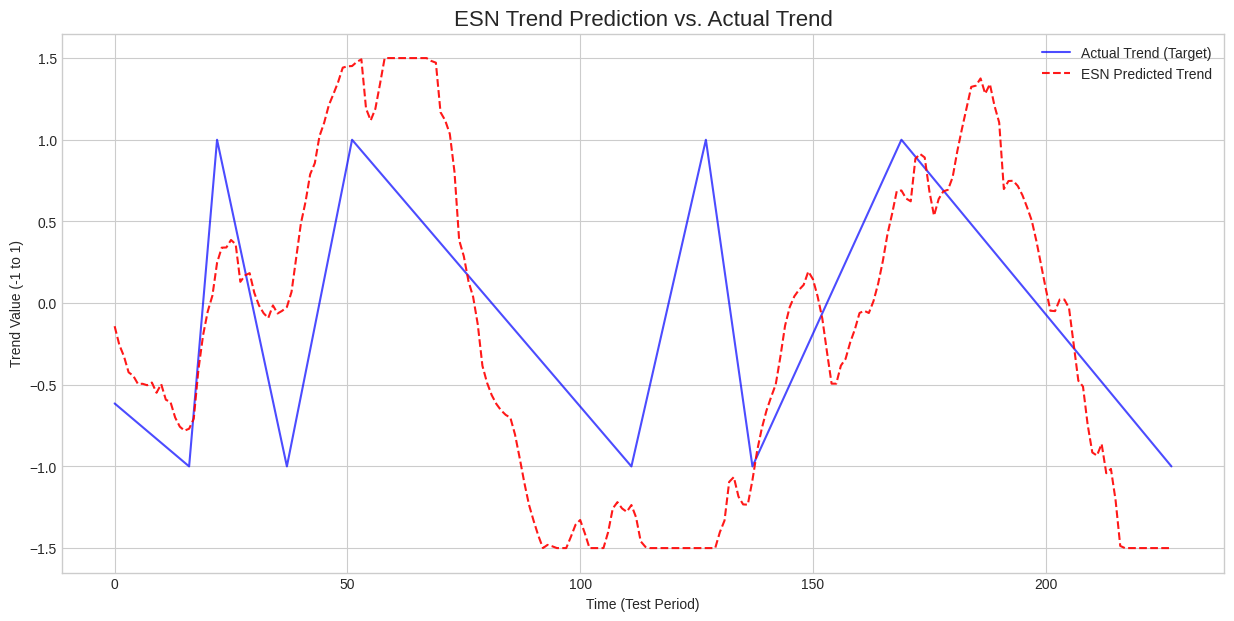

In [38]:
# ============================== 결과 시각화 ==============================
print("\n 이진 시그널 평가 결과:")
print(f"  - Accuracy: {acc:.4f}")                # 예측 방향이 맞았는지 (매수/매도)
print(f"  - F1 Score (macro): {f1:.4f}")         # Precision, Recall의 균형

print("\n ESN 최적 시그널 백테스트 결과")
print(f"  - Profit: {profit * 100:.2f}%")        # 절대 수익률
print(f"  - MDD: {mdd * 100:.2f}%")              # 리스크
print(f"  - Sharpe Ratio: {sharpe:.3f}")         # 실제 수익 기반 평가
print(f"  - NRMSE: {test_nrmse_score:.4f}")      # RMSE를 정규화한 값 (보조 지표)
print(f"  - R²: {test_rsquare_score:.4f}")       # 결정 계수
print(f"  - Sign Accuracy: {sign_accuracy:.4f}") # sign(y_true) == sign(y_pred) 비율

plt.figure(figsize=(15, 7))
plt.title("ESN Trend Prediction vs. Actual Trend", fontsize=16)
plt.xlabel("Time (Test Period)")
plt.ylabel("Trend Value (-1 to 1)")
plt.plot(Y_test, label="Actual Trend (Target)", color='blue', alpha=0.7)
plt.plot(Y_predicted, label="ESN Predicted Trend", color='red', linestyle='--', alpha=0.9)
plt.legend()
plt.grid(True)
plt.show()

### 🗒️ ESN 최적 파라미터 사용 백테스트 결과 해석

| 지표 (Metric)       | 값 (Value) | 해석 (Interpretation)                                                       |
|---------------------|------------|------------------------------------------------------------------------------|
| 수익률 (Profit)     | 22.05%     | - 전략의 효과성을 보여주는 매우 높은 수익.                                 |
| 최대 낙폭 (MDD)     | -8.59%     | - 높은 수익률에 비해 손실폭이 작아 안정적인 리스크 (10% 미만은 우수) |
| 샤프 지수 (Sharpe Ratio) | 1.143      | - 변동성 대비 수익률이 매우 뛰어남 (1 이상은 우수)      |
| NRMSE               | 0.2778    | - 비교적 양호한 오차 (0에 가까울수록 좋음)     |
| R² (결정 계수)      | 0.1337    | - 트렌드 움직임의 일부(약 13%)를 설명할 수 있는 예측 모델              |
| 부호 정확도 (Sign Accuracy) | 80.65%     | - 정확한 값은 못 맞춰도, 트렌드의 방향에 대한 예측은 정확.           |

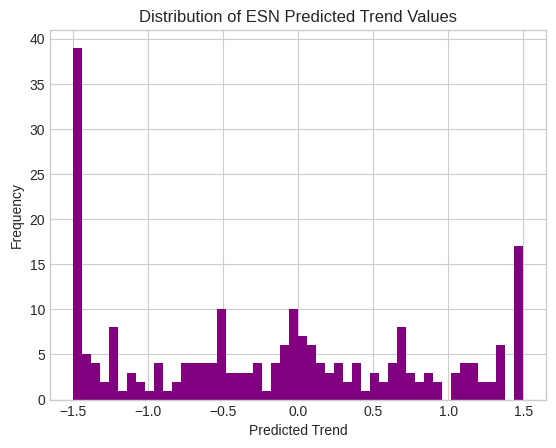

In [39]:
plt.hist(Y_predicted.flatten(), bins=50, color='purple')
plt.title("Distribution of ESN Predicted Trend Values")
plt.xlabel("Predicted Trend")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

In [ ]:
# 튜닝 모델과 기본값 모델 성능 비교
default_params = {
    'reservoir_units': 200,
    'leak_rate': 0.3,
    'spectral_radius': 1.0,
    'input_scaling': 1.0,
    'ridge_param': 1e-4
}

# ==================== 기본값 모델로 백테스트 ====================

# 1) 모델 정의
reservoir_default = Reservoir(
    units=default_params['reservoir_units'],
    lr=default_params['leak_rate'],
    sr=default_params['spectral_radius'],
    input_scaling=default_params['input_scaling']
)
readout_default = Ridge(ridge=default_params['ridge_param'])

# 2) 학습
reservoir_states_train_def = reservoir_default.run(X_train)
readout_default.fit(reservoir_states_train_def, Y_train)

# 3) 예측
reservoir_states_test_def = reservoir_default.run(X_test)
Y_pred_default = readout_default.run(reservoir_states_test_def)
Y_pred_default = np.clip(Y_pred_default, -1.5, 1.5)

# 4) 시그널 변환
final_signals_default = np.zeros_like(Y_pred_default)
final_signals_default[Y_pred_default < -trading_threshold] = 1
final_signals_default[Y_pred_default >  trading_threshold] = -1

true_signals_default = np.zeros_like(Y_test)
true_signals_default[Y_test < -trading_threshold] = 1
true_signals_default[Y_test >  trading_threshold] = -1

# 5) 평가
acc_default = accuracy_score(true_signals_default, final_signals_default)
f1_default = f1_score(true_signals_default, final_signals_default, average='macro')

# 6) 백테스트
df_for_backtest_default = df_final_esn_data.iloc[split_point:].copy()
signals_1d_default = final_signals_default.flatten()
assert len(df_for_backtest_default) == len(signals_1d_default)

profit_def, mdd_def, sharpe_def = backtest(df_for_backtest_default, signals_1d_default)

In [41]:
# ==================== 결과 비교 ====================
print("\n[튜닝 모델 결과]")
print(f"Accuracy: {acc:.4f}, F1: {f1:.4f}, Profit: {profit:.4%}, MDD: {mdd:.4%}, Sharpe: {sharpe:.3f}")

print("\n[기본값 모델 결과]")
print(f"Accuracy: {acc_default:.4f}, F1: {f1_default:.4f}, Profit: {profit_def:.4%}, MDD: {mdd_def:.4%}, Sharpe: {sharpe_def:.3f}")


[튜닝 모델 결과]
Accuracy: 0.6930, F1: 0.6321, Profit: 23.2500%, MDD: -8.5943%, Sharpe: 1.194

[기본값 모델 결과]
Accuracy: 0.4079, F1: 0.3603, Profit: 23.2500%, MDD: -8.5943%, Sharpe: 1.194


### 🔁 Repeat 5 times for t-test (ESN)
* 위에서 최적화 된 하이퍼파라미터로 진행!

In [ ]:
# {'input_scaling': 0.8, 'leak_rate': 0.3, 'reservoir_units': 200, 'ridge_param': 0.0001, 'spectral_radius': 0.8}
def run_esn_once(X_train, Y_train, X_test, Y_test, df_for_backtest, trading_threshold=0.2,
                 reservoir_units=200, leak_rate=0.3, spectral_radius=0.8, input_scaling=0.8, ridge_param=0.0001, seed=None):

    if seed is not None:
        np.random.seed(seed)

    # 1. ESN 모델 구성
    reservoir = Reservoir(units=reservoir_units, lr=leak_rate, sr=spectral_radius, input_scaling=input_scaling, seed=seed)
    readout = Ridge(ridge=ridge_param)

    # 2. 학습 및 예측
    reservoir_states_train = reservoir.run(X_train)
    readout.fit(reservoir_states_train, Y_train)
    reservoir_states_test = reservoir.run(X_test)
    Y_predicted = readout.run(reservoir_states_test)
    Y_predicted = np.clip(Y_predicted, -1.5, 1.5)

    # 3. 시그널 변환
    final_signals = np.zeros_like(Y_predicted)
    final_signals[Y_predicted < -trading_threshold] = 1  # 매수
    final_signals[Y_predicted >  trading_threshold] = -1  # 매도

    true_signals = np.zeros_like(Y_test)
    true_signals[Y_test < -trading_threshold] = 1
    true_signals[Y_test >  trading_threshold] = -1

    # 4. 평가 지표 계산
    nrmse_score = nrmse(Y_test, Y_predicted)
    r2_score = rsquare(Y_test, Y_predicted)
    acc = accuracy_score(true_signals, final_signals)
    f1 = f1_score(true_signals, final_signals, average='macro')

    # 5. 백테스트
    profit, mdd, sharpe = backtest(df_for_backtest, final_signals.flatten())

    return {
        'NRMSE': nrmse_score,
        'R²': r2_score,
        'Accuracy': acc,
        'f1': f1,
        'Profit': profit,
        'MDD': mdd,
        'Sharpe': sharpe
    }

results = []
for i in range(5):
    result = run_esn_once(X_train, Y_train, X_test, Y_test, df_for_backtest, seed=i)
    results.append(result)

In [43]:
# 모든 지표를 DataFrame으로 출력
df_results = pd.DataFrame(results)
print("\n ESN 반복 결과 (5회):")
print(df_results)


 ESN 반복 결과 (5회):
      NRMSE        R²  Accuracy        f1  Profit       MDD   Sharpe
0  0.444286 -1.217632  0.600877  0.537643  0.2325 -0.085943  1.19392
1  0.373220 -0.564922  0.592105  0.528860  0.2325 -0.085943  1.19392
2  0.441957 -1.194435  0.434211  0.371832  0.2325 -0.085943  1.19392
3  0.373695 -0.568906  0.552632  0.448224  0.2325 -0.085943  1.19392
4  0.429115 -1.068762  0.517544  0.450517  0.2325 -0.085943  1.19392


### 🔁 Repeat 5 times for t-test (GRU)

In [ ]:
# 시드 고정 함수
def set_seed(seed):
    torch.manual_seed(seed)
    np.random.seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# 슬라이딩 윈도우 생성 함수
def create_sequence_data(X, Y, seq_len):
    X_seq, Y_seq = [], []
    for i in range(len(X) - seq_len + 1):
        X_seq.append(X[i:i+seq_len])
        Y_seq.append(Y[i+seq_len-1])  # 마지막 시점 예측
    return np.array(X_seq), np.array(Y_seq)

# GRU 모델 정의
class GRUModel(nn.Module):
    def __init__(self, input_dim, hidden_dim=256, output_dim=1, num_layers=2):
        super(GRUModel, self).__init__()
        self.gru = nn.GRU(input_dim, hidden_dim, num_layers, batch_first=True)
        # self.fc = nn.Linear(hidden_dim, output_dim)
        self.fc = nn.Sequential(
            nn.Linear(hidden_dim, output_dim),
            nn.Tanh()
        )

    def forward(self, x):
        out, _ = self.gru(x)
        return self.fc(out[:, -1, :])

# GRU 실행 함수
def run_gru_once_with_split(df, feature_columns, seq_len=20, trading_threshold=0.2, seed=0,
                            hidden_dim=256, lr=0.0001, epochs=200):

    print(f"\n[시드 {seed}] GRU 실행 시작")
    set_seed(seed)

    # 1. 데이터 분할 (ESN과 동일: 마지막 12개월을 테스트로)
    split_date = df.index.max() - pd.DateOffset(months=12)
    df_train = df[df.index < split_date].copy()
    df_test  = df[df.index >= split_date].copy()

    X_train, Y_train = df_train[feature_columns].values, df_train[['trend']].values
    X_test, Y_test   = df_test[feature_columns].values,  df_test[['trend']].values

    # 2. 시퀀스 생성
    X_train_seq, Y_train_seq = create_sequence_data(X_train, Y_train, seq_len)
    X_test_seq, Y_test_seq   = create_sequence_data(X_test,  Y_test,  seq_len)

    # 3. 텐서 변환
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    X_train_tensor = torch.tensor(X_train_seq, dtype=torch.float32).to(device)
    Y_train_tensor = torch.tensor(Y_train_seq, dtype=torch.float32).to(device)
    X_test_tensor  = torch.tensor(X_test_seq,  dtype=torch.float32).to(device)
    Y_test_tensor  = torch.tensor(Y_test_seq,  dtype=torch.float32).to(device)

    # 4. 모델 구성
    input_dim = X_train.shape[1]
    model = GRUModel(input_dim=input_dim, hidden_dim=hidden_dim).to(device)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    # 5. 학습
    model.train()
    for epoch in range(epochs):
        optimizer.zero_grad()
        output = model(X_train_tensor)
        loss = criterion(output, Y_train_tensor)
        loss.backward()
        optimizer.step()

    # 6. 예측
    model.eval()
    with torch.no_grad():
        Y_pred = model(X_test_tensor).cpu().numpy()
    Y_pred = np.clip(Y_pred, -1.5, 1.5)

    # 7. 시그널 변환
    final_signals = np.zeros_like(Y_pred)
    final_signals[Y_pred < -trading_threshold] = 1
    final_signals[Y_pred >  trading_threshold] = -1

    true_signals = np.zeros_like(Y_test_seq)
    true_signals[Y_test_seq < -trading_threshold] = 1
    true_signals[Y_test_seq >  trading_threshold] = -1

    # 8. 평가 지표 계산
    acc = accuracy_score(true_signals, final_signals)
    f1 = f1_score(true_signals, final_signals, average='macro')
    nrmse_score = nrmse(Y_test_seq, Y_pred)
    r2_score = rsquare(Y_test_seq, Y_pred)

    print(f"예측값 분포: {np.min(Y_pred):.3f} ~ {np.max(Y_pred):.3f}")
    print(f"시그널 분포: {np.unique(final_signals, return_counts=True)}")

    return {
        'NRMSE': nrmse_score,
        'R²': r2_score,
        'Accuracy': acc,
        'f1': f1,
        'Y_pred': Y_pred,
        'final_signals': final_signals,
        'true_signals': true_signals
    }

gru_results = []

for seed in range(5):
    result = run_gru_once_with_split(
        df=df_final_esn_data,
        feature_columns=['SMA', 'EMA', 'MACD', 'RSI', 'Stochastic', 'ROC'],
        seq_len=20,  # 원하는 시퀀스 길이
        trading_threshold=0.2,
        seed=seed,
        hidden_dim=64,
        lr=0.0001,
        epochs=200
    )

    # 백테스트용 시계열 재구성
    split_date = df_final_esn_data.index.max() - pd.DateOffset(months=12)
    df_bt = df_final_esn_data[df_final_esn_data.index >= split_date].copy()
    df_bt = df_bt.iloc[20-1:]  # 시퀀스 길이만큼 앞을 자름
    signal_1d = result['final_signals'].flatten()
    assert len(df_bt) == len(signal_1d), "❌ 시그널과 백테스트 데이터 길이 불일치"

    profit, mdd, sharpe = backtest(df_bt, signal_1d)
    if np.isnan(sharpe): sharpe = 0.0

    result['Profit'] = profit
    result['MDD'] = mdd
    result['Sharpe'] = sharpe

    gru_results.append(result)

In [45]:
# 결과 요약
df_gru_results = pd.DataFrame(gru_results)[['NRMSE', 'R²', 'Accuracy', 'f1', 'Profit', 'MDD', 'Sharpe']]
print("\nGRU 반복 결과 요약 (5회):")
print(df_gru_results)


GRU 반복 결과 요약 (5회):
      NRMSE        R²  Accuracy        f1  Profit  MDD  Sharpe
0  0.255354  0.263309  0.495690  0.506984     0.0 -0.0     0.0
1  0.250663  0.290132  0.534483  0.541450     0.0 -0.0     0.0
2  0.254877  0.266060  0.512931  0.515540     0.0 -0.0     0.0
3  0.251770  0.283846  0.491379  0.496444     0.0 -0.0     0.0
4  0.258746  0.243611  0.439655  0.452816     0.0 -0.0     0.0


### ✔️ t-test

In [46]:
metrics = ['NRMSE', 'R²', 'Accuracy', 'f1', 'Profit', 'MDD', 'Sharpe']
results_list = []

for metric in metrics:
    x_esn = df_results[metric].dropna().values
    x_gru = df_gru_results[metric].dropna().values

    t_stat, p_value_two_sided = ttest_ind(x_gru, x_esn, equal_var=False)
    p_value_one_sided = p_value_two_sided / 2

    mean_gru = x_gru.mean()
    mean_esn = x_esn.mean()
    better = "GRU" if mean_gru > mean_esn else "ESN"

    if p_value_one_sided < 0.01:
        sig = "⭐⭐ 매우 유의미 (p < 0.01)"
    elif p_value_one_sided < 0.05:
        sig = "⭐ 유의미 (p < 0.05)"
    else:
        sig = "❌ 통계적으로 유의하지 않음"

    results_list.append({
        'metric': metric,
        'GRU 평균': round(mean_gru, 4),
        'ESN 평균': round(mean_esn, 4),
        't-statistic': round(t_stat, 4),
        'p-value (GRU > ESN)': round(p_value_one_sided, 4),
        '우세 모델': better,
        '유의성 판정': sig
    })

# DataFrame으로 변환
df_ttest_summary = pd.DataFrame(results_list)

# 결과 출력
df_ttest_summary.head()

/usr/local/lib/python3.11/dist-packages/scipy/stats/_axis_nan_policy.py:586: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)


,metric,GRU 평균,ESN 평균,t-statistic,p-value (GRU > ESN),우세 모델,유의성 판정
0,NRMSE,0.2543,0.4125,-9.7684,0.0003,ESN,⭐⭐ 매우 유의미 (p < 0.01)
1,R²,0.2694,-0.9229,8.0691,0.0006,GRU,⭐⭐ 매우 유의미 (p < 0.01)
2,Accuracy,0.4948,0.5395,-1.3100,0.1190,ESN,❌ 통계적으로 유의하지 않음
3,f1,0.5026,0.4674,1.0455,0.1689,GRU,❌ 통계적으로 유의하지 않음
4,Profit,0.0000,0.2325,-inf,0.0000,ESN,⭐⭐ 매우 유의미 (p < 0.01)


<Figure size 1400x600 with 0 Axes>

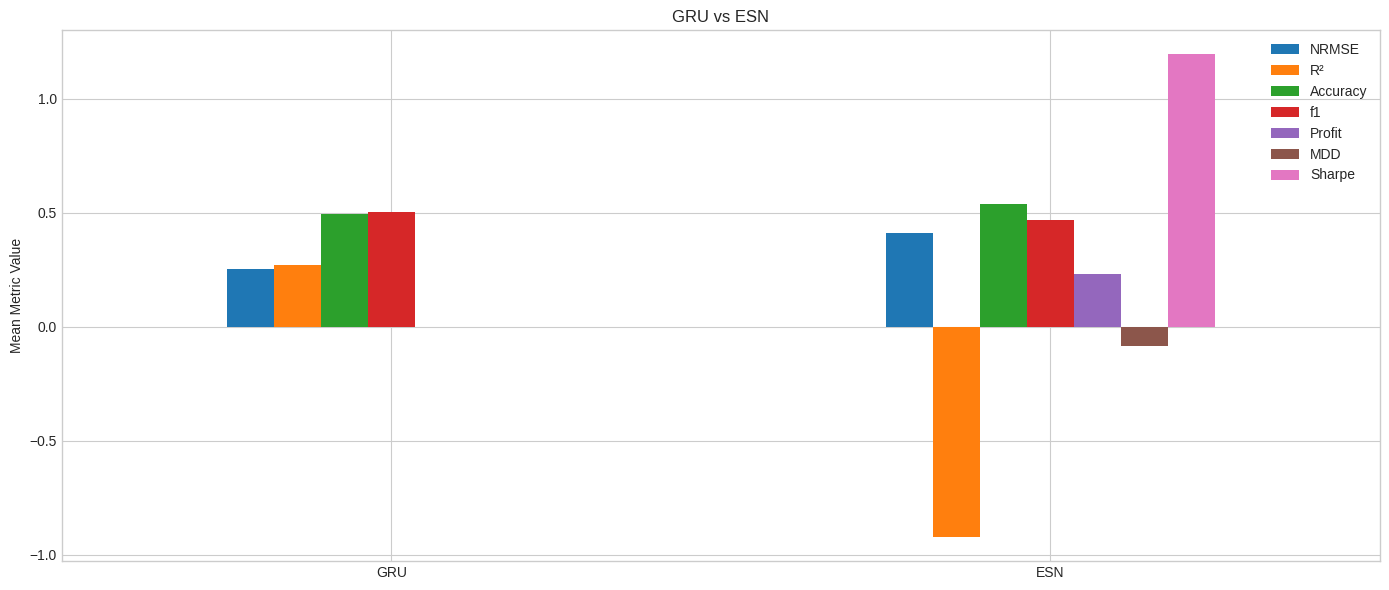

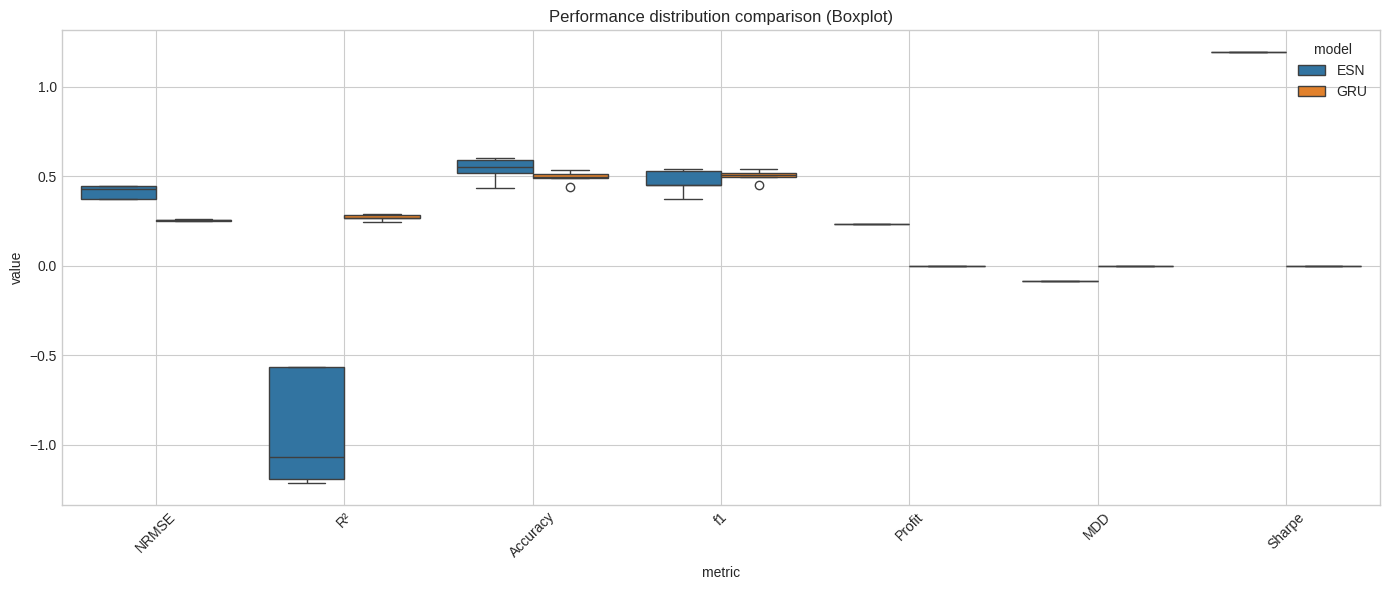

In [47]:
# 1. 평균 비교 시각화 (Barplot)
def plot_mean_bar(df_esn, df_gru, metrics):
    mean_esn = df_esn[metrics].mean()
    mean_gru = df_gru[metrics].mean()

    mean_df = pd.DataFrame({'GRU': mean_gru, 'ESN': mean_esn}).T
    mean_df = mean_df[metrics]  # column order 유지

    plt.figure(figsize=(14, 6))
    mean_df.plot(kind='bar', figsize=(14, 6))
    plt.title("GRU vs ESN")
    plt.ylabel("Mean Metric Value")
    plt.xticks(rotation=0)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# 2. Boxplot: 분포 비교
def plot_metric_boxplot(df_esn, df_gru, metrics):
    df_esn_melt = df_esn[metrics].copy()
    df_gru_melt = df_gru[metrics].copy()
    df_esn_melt['model'] = 'ESN'
    df_gru_melt['model'] = 'GRU'
    df_all = pd.concat([df_esn_melt, df_gru_melt], axis=0)

    df_long = df_all.melt(id_vars='model', var_name='metric', value_name='value')

    plt.figure(figsize=(14, 6))
    sns.boxplot(data=df_long, x='metric', y='value', hue='model')
    plt.title("Performance distribution comparison (Boxplot)")
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

plot_mean_bar(df_results, df_gru_results, metrics)
plot_metric_boxplot(df_results, df_gru_results, metrics)

### 🔖 결론 (TJX)
* 예측 성능 관점 (Accuracy, F1, NRMSE) → ESN 우세
* 투자 위험 관점 (MDD) → ESN 압도적 우세
* 투자 수익 관점 (Profit, Sharpe) → 통계적으로 유의미한 차이 없음

> 이유
>- 정확성과 안정성: ESN은 Accuracy와 MDD 두 지표에서 GRU보다 통계적으로 유의미하게 우수한 성능을 보임(p < 0.05). 이는 ESN이 더 신뢰할 수 있고 리스크 관리에 강점이 있음을 의미
>- 수익성의 우위는 불확실: Profit과 Sharpe Ratio는 ESN의 평균값이 더 높았지만, 통계적으로 유의미한 차이는 없었음.
>- **결론**: ESN은 더 정확하게 예측하고 훨씬 더 안정적이면서 수익성 측면에서도 밀리지 않으므로 전반적으로 GRU보다 더 우수함